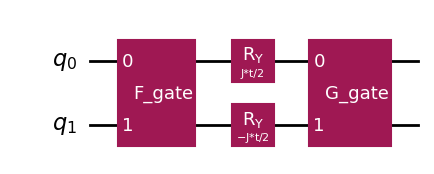

In [14]:
# Creating two site interactions:

from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister, ClassicalRegister

# Hopping Term
## Creating the f_gates:
f_circ =  QuantumCircuit(2)
f_circ.h([0,1])
f_circ.s([0,1])
f_circ.h([0,1])
f_circ.cx(0,1)
f_circ.h(1)
f_circ.z(1)
f_circ.s([0,1])
f_circ.h([0,1])

f_gate = f_circ.to_gate(label = 'F_gate')

## Creating the g_gates:
g_circ =  QuantumCircuit(2)
g_circ.h([0,1])
g_circ.z(0)
g_circ.s(0)
g_circ.s(1)
g_circ.h(1)
g_circ.cx(0,1)
g_circ.h([0,1])
g_circ.z([0,1])
g_circ.s([0,1])
g_circ.h([0,1])

g_gate = g_circ.to_gate(label = 'G_gate')

## Creating the hopping gate
t = Parameter(fr't')
J = Parameter(f'J')

# cycles = 3

# sysqubits = 1
# timeresamples = 10

# targ = Parameter(r'$E_\odot$')
# t = [Parameter(fr'$t_{i}$') for i in range(cycles)]


hop_circ = QuantumCircuit(2)
hop_circ.append(f_gate, [0,1])
hop_circ.ry((J*t)/2, 0)
hop_circ.ry((-1*J*t)/2, 1)
hop_circ.append(g_gate, [0,1])

A_gate = hop_circ.to_gate(label = "A_gate") # Hopping gate between nearest neighbors
hop_circ.draw('mpl')

In [16]:
# Conservation Test
from qiskit.quantum_info import Statevector

circuit = QuantumCircuit(2)
# circuit.x(0)
# circuit.x(1)
circuit.append(A_gate, range(2))
parameters = {t:0.1, J : -1}
circuit1 = circuit.assign_parameters(parameters, inplace=False)

# Get the statevector
state = Statevector.from_instruction(circuit1)

# Display the statevector
print("Statevector:", state)


Statevector: Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


In [3]:
# Creating onsite operator
U = Parameter(f'U')

onsite_circ = QuantumCircuit(2)
onsite_circ.cx(0,1)
onsite_circ.ry(2*U*t, 1)
onsite_circ.cx(0,1)

onsite_circ.draw('mpl')

B_gate = onsite_circ.to_gate(label = f'B_gate')

In [4]:
from qiskit import QuantumCircuit

def hubbard_model_step(num_sites_input):
    num_sites = num_sites_input  # Number of sites in the chain
    num_qubits = num_sites * 2   # Each site has two qubits (spin-up and spin-down)

    # Initialize the Hubbard circuit
    hubbard = QuantumCircuit(num_qubits)
    
    # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits, grouping by even and odd sites
    # Even-indexed sites for spin-up qubits
    for site in range(0, num_sites - 1, 2):  # Only even sites
        spin_up_qubit_1 = site * 2
        spin_up_qubit_2 = (site + 1) * 2
        hubbard.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

    # Odd-indexed sites for spin-up qubits
    for site in range(1, num_sites - 1, 2):  # Only odd sites
        spin_up_qubit_1 = site * 2
        spin_up_qubit_2 = (site + 1) * 2
        hubbard.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

    # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits, grouping by even and odd sites
    # Even-indexed sites for spin-down qubits
    for site in range(0, num_sites - 1, 2):  # Only even sites
        spin_down_qubit_1 = site * 2 + 1
        spin_down_qubit_2 = (site + 1) * 2 + 1
        hubbard.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

    # Odd-indexed sites for spin-down qubits
    for site in range(1, num_sites - 1, 2):  # Only odd sites
        spin_down_qubit_1 = site * 2 + 1
        spin_down_qubit_2 = (site + 1) * 2 + 1
        hubbard.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

    # Apply B_gate for on-site interactions on each site
    for site in range(num_sites):
        spin_up_qubit = site * 2
        spin_down_qubit = site * 2 + 1
        hubbard.append(B_gate, [spin_up_qubit, spin_down_qubit])

    return hubbard.to_gate(label='TrotterStep')

In [5]:
def trotter_evolution(J_input, U_input, delta_t, r, num_sites):
    num_qubits = num_sites * 2  # Calculate number of qubits based on sites
    trotter_circuit = QuantumCircuit(num_qubits)

    # Create the parameterized Hubbard model gate for each step
    hubbard_step_gate = hubbard_model_step(num_sites)

    # Append the Hubbard model step for each Trotter step
    for _ in range(r):
        # Assign parameters for the step
        trotter_circuit.append(hubbard_step_gate, range(num_qubits))
    
    # Assign the values of the parameters
    parameters = {t: delta_t, J: J_input, U: U_input}
    trotter_circuit = trotter_circuit.assign_parameters(parameters)

    # Convert to a gate to use in larger circuits, if desired
    # circuit_gate = trotter_circuit.to_gate(label=f"Trotter_{r}_steps")
    return trotter_circuit.to_gate(label = f"Trotter_{r}_steps")


In [6]:
from qiskit.circuit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

num_sites = 4
num_qubits = num_sites*2

gate = trotter_evolution(1,-1,0.01, 20, 4)

circuit = QuantumCircuit(num_qubits)
circuit.append(gate, range(num_qubits))

# Get the statevector
state = Statevector.from_instruction(circuit)

# Display the statevector
print("Statevector:", state)
       

Statevector: Statevector([ 9.22773133e-01-3.76680867e-03j,
              0.00000000e+00+0.00000000e+00j,
             -1.86502035e-01-8.35537168e-03j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              7.04231913e-16-8.57217261e-16j,
              0.00000000e+00+0.00000000e+00j,
              8.57797471e-17-1.88721338e-16j,
             -1.86169957e-01-1.74784637e-02j,
              0.00000000e+00+0.00000000e+00j,
              3.77025720e-02+2.99688476e-03j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              7.63504441e-18-2.90697638e-17j,
              0.00000000e+00+0.00000000e+00j,
             -1.63983252e-18-2.25521483e-19j,
              0.00000000e+00+0.00000000e+00j,
              4.08702449e-17+4.05717022e-17j,
              0.00000000e+00+0.00000000e+00j,
              7.44337425e-18+2.37343429e-18j,
              7.78358055e-19-5.56470319e-19j,
              0.00000

In [7]:
import numpy as np
np.linalg.norm(state)

0.9999999999998513

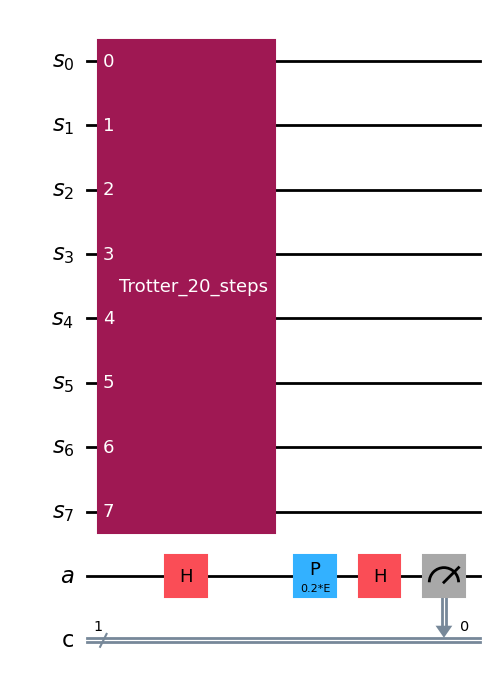

In [10]:
num_sites = 4
num_qubits = num_sites*2

step_size = 20
delta_t = 0.01

evolution_gate = trotter_evolution(1,-1,delta_t,step_size, 4)
sys = QuantumRegister(num_qubits, 's')
aux = QuantumRegister(1, 'a')
classical = ClassicalRegister(1, 'c')

circuit = QuantumCircuit(sys, aux, classical)

E_targ = Parameter('E')
total_t = delta_t*step_size

circuit.h(aux)
circuit.append(evolution_gate, range(num_qubits))
circuit.p(E_targ*total_t, aux)
circuit.h(aux)
circuit.measure(aux, classical)

circuit.draw('mpl')

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister, ClassicalRegister

# Define global parameters for hopping and on-site interactions
J = Parameter('J')
U = Parameter('U')

# Creating two site interactions:

# Hopping Term
## Creating the f_gates:
f_circ =  QuantumCircuit(2)
f_circ.h([0,1])
f_circ.s([0,1])
f_circ.h([0,1])
f_circ.cx(0,1)
f_circ.h(1)
f_circ.z(1)
f_circ.s([0,1])
f_circ.h([0,1])

f_gate = f_circ.to_gate(label = 'F_gate')

## Creating the g_gates:
g_circ =  QuantumCircuit(2)
g_circ.h([0,1])
g_circ.z(0)
g_circ.s(0)
g_circ.s(1)
g_circ.h(1)
g_circ.cx(0,1)
g_circ.h([0,1])
g_circ.z([0,1])
g_circ.s([0,1])
g_circ.h([0,1])

g_gate = g_circ.to_gate(label = 'G_gate')

hop_circ = QuantumCircuit(2)
hop_circ.append(f_gate, [0,1])
hop_circ.ry((J*t)/2, 0)
hop_circ.ry((-1*J*t)/2, 1)
hop_circ.append(g_gate, [0,1])

A_gate = hop_circ.to_gate(label = "A_gate") # Hopping gate between nearest neighbors

onsite_circ = QuantumCircuit(2)
onsite_circ.cx(0,1)
onsite_circ.ry(2*U*t, 1)
onsite_circ.cx(0,1)

onsite_circ.draw('mpl')

B_gate = onsite_circ.to_gate(label = f'B_gate')


# Combined function for the Trotter evolution with auxiliary control and measurement
def rodeo_circuit(J_value, U_value, delta_t, total_t, num_sites, cycles, targ, gamma_input):
    gamma = gamma_input
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)
    num_steps = total_t//delta_t # Calculate the number of steps required
    effective_t = num_steps*delta_t
    E_targ = Parameter('E')  # Target energy parameter
    phase_t = Parameter(fr'$t_p$')
    t = [Parameter(fr'$t_{i}$') for i in range(cycles)]

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    classical = ClassicalRegister(1, 'c')
    circuit = QuantumCircuit(sys, aux, classical)

    # Apply Hadamard on the auxiliary qubit to create superposition
    circuit.h(aux)
    circuit.cz([sys[0], sys[1]], aux)

    # Build the Trotter evolution directly within this function
    for i in range(cycles):
        tsamples = ((1 / gamma) * np.random.randn(num_cycles))
        for _ in range(num_steps):
            # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
            for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
                spin_up_qubit_1 = site * 2
                spin_up_qubit_2 = (site + 1) * 2
                circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

            for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
                spin_up_qubit_1 = site * 2
                spin_up_qubit_2 = (site + 1) * 2
                circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

            # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
            for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
                spin_down_qubit_1 = site * 2 + 1
                spin_down_qubit_2 = (site + 1) * 2 + 1
                circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

            for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
                spin_down_qubit_1 = site * 2 + 1
                spin_down_qubit_2 = (site + 1) * 2 + 1
                circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

            
            # Add CX gates for every two system qubit
            for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
                circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
                if i + 2 < num_qubits:        # Ensure we're within bounds
                    circuit.cx(aux, sys[i + 2])

            # Apply B_gate for on-site interactions on each site
            for site in range(num_sites):
                spin_up_qubit = site * 2
                spin_down_qubit = site * 2 + 1
                circuit.append(B_gate, [spin_up_qubit, spin_down_qubit])

            # Add CX gates for every two system qubit
            for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
                circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
                if i + 2 < num_qubits:        # Ensure we're within bounds
                    circuit.cx(aux, sys[i + 2])

        circuit.cz([sys[0], sys[1]], aux)
        # Apply phase rotation on auxiliary qubit conditioned on E_targ and total evolution time
        circuit.p(E_targ * phase_t, aux)
        # Apply a final Hadamard on auxiliary qubit and measure it
        circuit.h(aux)
        circuit.measure(aux, classical)
        time_parameter_binds = zip(t[i], tsamples)
        time_parameters = dict(time_parameter_binds)
        timed_circuit = circuit.assign_parameters(time_parameters, inplace = False)

    parameters = {J:J_value, U:U_value, t:effective_t, E_targ:targ}
    trotter_circuit = circuit.assign_parameters(parameters)

    return trotter_circuit

E_targ = 0.2
dt = 0.1
trottersteps = 1
num_cycles = 1

circuit = rodeo_circuit(J_value = 1,U_value = -1,delta_t = dt,num_steps = trottersteps,
                        num_sites = 2,cycles = num_cycles,targ = 2*E_targ*dt*trottersteps)

NameError: name 't' is not defined

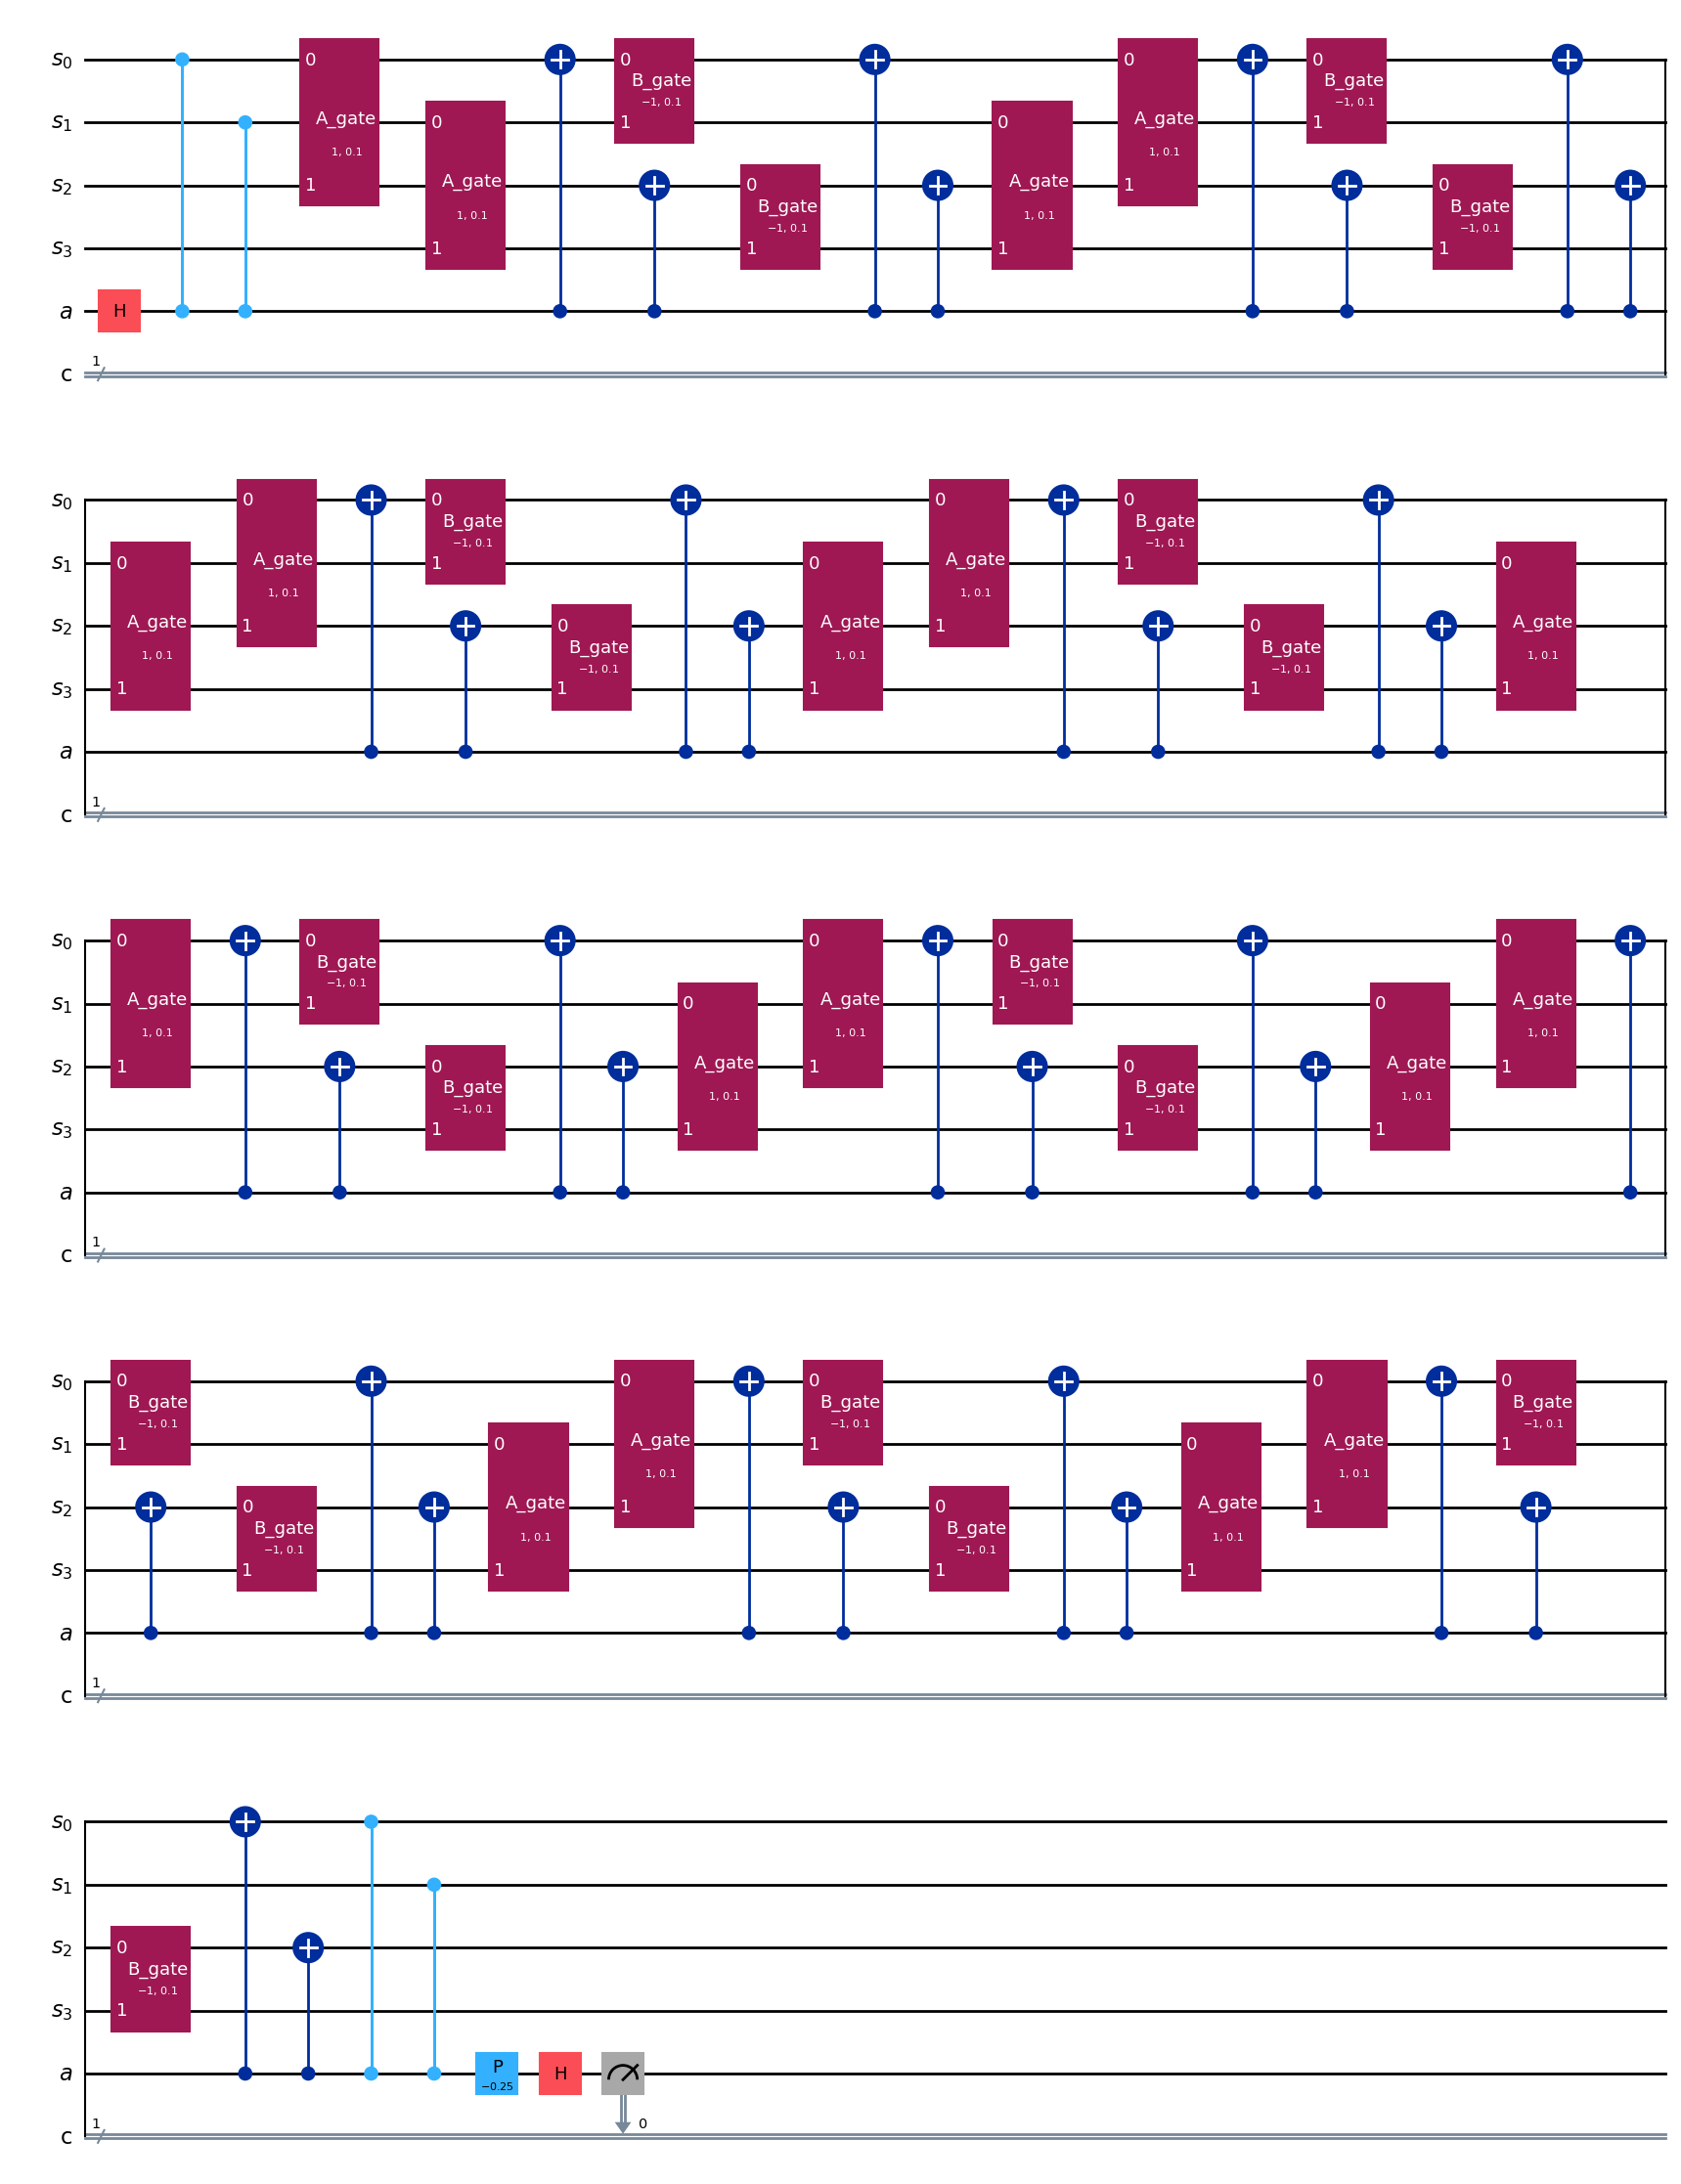

In [ ]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter

# Define global parameters for hopping and on-site interactions
J = Parameter('J')
U = Parameter('U')
dt = Parameter('dt')

# Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate():
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')
    
    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * dt) / 2, 0)
    hop_circ.ry((-1 * J * dt) / 2, 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label="A_gate")

A_gate = create_hopping_gate()

# On-site interaction gate
def create_onsite_gate():
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.ry(2 * U * dt, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label="B_gate")

B_gate = create_onsite_gate()

# Combined function for the Trotter evolution with auxiliary control and measurement
def rodeo_circuit(J_value, U_value, delta_t, total_t, num_sites, cycles, targ, gamma_input):
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)
    num_steps = int(total_t // delta_t)  # Calculate the number of Trotter steps
    E_targ = Parameter('E')  # Target energy parameter
    t_params = [Parameter(f't_{i}') for i in range(cycles)]
    
    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    classical = ClassicalRegister(cycles, 'c')
    circuit = QuantumCircuit(sys, aux, classical)
    
    # Apply Hadamard on the auxiliary qubit
    circuit.h(aux)

    # Build the Trotter evolution with randomized time samples per cycle
    for cycle in range(cycles):
        circuit.cz([sys[0], sys[1]], aux)
        # Generate random time samples for the current cycle based on gamma
        time_samples = (1 / gamma_input) * np.random.randn(num_steps)

        for step in range(num_steps):
            # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
            for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
                spin_up_qubit_1 = site * 2
                spin_up_qubit_2 = (site + 1) * 2
                circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

            for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
                spin_up_qubit_1 = site * 2
                spin_up_qubit_2 = (site + 1) * 2
                circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

            # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
            for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
                spin_down_qubit_1 = site * 2 + 1
                spin_down_qubit_2 = (site + 1) * 2 + 1
                circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

            for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
                spin_down_qubit_1 = site * 2 + 1
                spin_down_qubit_2 = (site + 1) * 2 + 1
                circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

            
            # Add CX gates for every two system qubit
            for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
                circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
                if i + 2 < num_qubits:        # Ensure we're within bounds
                    circuit.cx(aux, sys[i + 2])

            # Apply B_gate for on-site interactions on each site
            for site in range(num_sites):
                spin_up_qubit = site * 2
                spin_down_qubit = site * 2 + 1
                circuit.append(B_gate, [spin_up_qubit, spin_down_qubit])

            # Add CX gates for every two system qubit
            for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
                circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
                if i + 2 < num_qubits:        # Ensure we're within bounds
                    circuit.cx(aux, sys[i + 2])
        circuit.cz([sys[0], sys[1]], aux)
        # Apply phase rotation and Hadamard on auxiliary qubit
        # circuit.p(E_targ * t_params[cycle], aux)
        circuit.p(t_params[cycle], aux)
        circuit.h(aux)
        circuit.measure(aux, classical[cycle])
    
    # Assign parameters to the circuit
    time_binds = dict(zip(t_params, time_samples))
    # parameter_binds = {J: J_value, U: U_value, E_targ: targ, dt:delta_t}
    parameter_binds = {J: J_value, U: U_value, dt:delta_t}
    final_circuit = circuit.assign_parameters({**time_binds, **parameter_binds}, inplace=False)
    
    
    return final_circuit

# Example usage
E_targ = 0.2
dt_val = 0.1
total_time = 1.0
num_sites = 2
num_cycles = 1
gamma_input = 0.5

circuit = rodeo_circuit(
    J_value=1, U_value=-1, delta_t=dt_val, total_t=total_time, 
    num_sites=num_sites, cycles=num_cycles, targ=2 * E_targ * dt_val * total_time, 
    gamma_input=gamma_input
)

circuit.draw('mpl')


In [28]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter

# Define global parameters for hopping and on-site interactions
J = Parameter('J')
U = Parameter('U')
dt = Parameter('dt')

# Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate():
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')
    
    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * dt) / 2, 0)
    hop_circ.ry((-1 * J * dt) / 2, 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label="A_gate")

A_gate = create_hopping_gate()

# On-site interaction gate
def create_onsite_gate():
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.ry(2 * U * dt, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label="B_gate")

B_gate = create_onsite_gate()

# Function for a single Rodeo cycle with Trotter evolution and auxiliary qubit measurement
def rodeo_cycle(J_value, U_value, delta_t, num_sites, E_target, gamma_input):
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)
    time_sample = (1 / gamma_input) * np.random.randn()
    num_steps = int(time_sample // delta_t)  # Number of Trotter steps within this cycle
    phase_t = Parameter('phase_t')  # Phase parameter for the auxiliary qubit rotation

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    classical = ClassicalRegister(1, 'c')
    circuit = QuantumCircuit(sys, aux, classical)

    # Apply Hadamard on the auxiliary qubit to create superposition
    circuit.h(aux)
    circuit.cz([sys[0], sys[1]], aux)

    # Generate random time sample for this cycle based on gamma

    # Trotter evolution within this single Rodeo cycle
    for step in range(num_steps):
 # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
            for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
                spin_up_qubit_1 = site * 2
                spin_up_qubit_2 = (site + 1) * 2
                circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

            for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
                spin_up_qubit_1 = site * 2
                spin_up_qubit_2 = (site + 1) * 2
                circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

            # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
            for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
                spin_down_qubit_1 = site * 2 + 1
                spin_down_qubit_2 = (site + 1) * 2 + 1
                circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

            for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
                spin_down_qubit_1 = site * 2 + 1
                spin_down_qubit_2 = (site + 1) * 2 + 1
                circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

            
            # Add CX gates for every two system qubit
            for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
                circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
                if i + 2 < num_qubits:        # Ensure we're within bounds
                    circuit.cx(aux, sys[i + 2])

            # Apply B_gate for on-site interactions on each site
            for site in range(num_sites):
                spin_up_qubit = site * 2
                spin_down_qubit = site * 2 + 1
                circuit.append(B_gate, [spin_up_qubit, spin_down_qubit])

            # Add CX gates for every two system qubit
            for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
                circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
                if i + 2 < num_qubits:        # Ensure we're within bounds
                    circuit.cx(aux, sys[i + 2])

    # Phase rotation based on the energy target and time sample
    circuit.cz([sys[0], sys[1]], aux)
    circuit.p(E_target * phase_t, aux)
    circuit.h(aux)
    circuit.measure(aux, classical)

    # Assign parameters to the circuit
    parameter_binds = {J: J_value, U: U_value, dt: delta_t, phase_t: time_sample}
    final_circuit = circuit.assign_parameters(parameter_binds, inplace=False)

    return final_circuit

# Example usage of a single Rodeo cycle
E_target = 0.2
dt_val = 0.1
num_sites = 2
gamma_input = 0.5

cycle_circuit = rodeo_cycle(
    J_value=1, U_value=-1, delta_t=dt_val, num_sites=num_sites, 
    E_target=E_target, gamma_input=gamma_input
)

cycle_circuit.draw('mpl')


CircuitError: 'Cannot bind parameters (J, dt, U) not present in the circuit.'

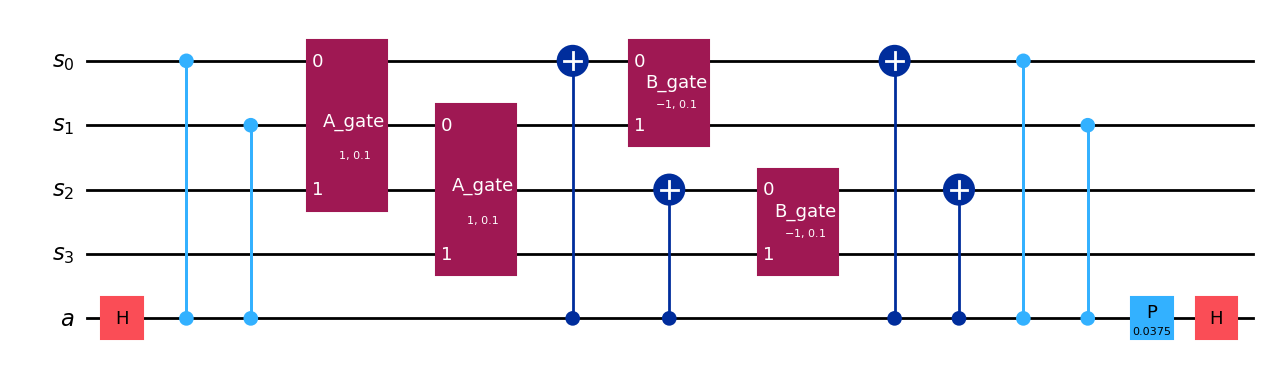

In [12]:
cycle_circuit4.draw('mpl')

In [9]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import Parameter

# Define global parameters for hopping and on-site interactions
J = Parameter('J')
U = Parameter('U')
dt = Parameter('dt')

# Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate():
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')
    
    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * dt) / 2, 0)
    hop_circ.ry((-1 * J * dt) / 2, 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label="A_gate")

A_gate = create_hopping_gate()

# On-site interaction gate
def create_onsite_gate():
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.ry(2 * U * dt, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label="B_gate")

B_gate = create_onsite_gate()

# Function for a single Rodeo cycle with Trotter evolution and auxiliary qubit control
def rodeo_cycle(J_value, U_value, delta_t, num_sites, E_target, gamma_input):
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)
    time_sample = (1 / gamma_input) * np.random.randn()
    num_steps = int(time_sample // delta_t)  # Number of Trotter steps within this cycle
    phase_t = Parameter('phase_t')  # Phase parameter for the auxiliary qubit rotation

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    circuit = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    circuit.h(aux)
    circuit.cz([sys[0], sys[1]], aux)

    # Trotter evolution within this single Rodeo cycle
    for step in range(num_steps):
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # Add CX gates for every two system qubits
        for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
            circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
            if i + 2 < num_qubits:        # Ensure we're within bounds
                circuit.cx(aux, sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            circuit.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # Add CX gates for every two system qubits
        for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
            circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
            if i + 2 < num_qubits:        # Ensure we're within bounds
                circuit.cx(aux, sys[i + 2])

    # Phase rotation based on the energy target and time sample
    circuit.cz([sys[0], sys[1]], aux)
    circuit.p(E_target * phase_t, aux)
    circuit.h(aux)

    # Assign parameters to the circuit
    parameter_binds = {J: J_value, U: U_value, dt: delta_t, phase_t: time_sample}
    final_circuit = circuit.assign_parameters(parameter_binds, inplace=False)

     # Convert the fully parameterized circuit into a gate with a dynamic label
    gate_label = f"Rodeo_{time_sample:.3f}_Evolution"
    rodeo_gate = final_circuit.to_gate(label=gate_label)
    
    return rodeo_gate

# Example usage of a single Rodeo cycle as a gate
E_target = 0.2
dt_val = 0.1
num_sites = 2
gamma_input = 0.5

rodeo_gate = rodeo_cycle(
    J_value=1, U_value=-1, delta_t=dt_val, num_sites=num_sites, 
    E_target=E_target, gamma_input=gamma_input
)

# Create a new circuit to add the Rodeo gate
test_circuit = QuantumCircuit(num_sites * 2 + 1)
test_circuit.append(rodeo_gate, range(num_sites * 2 + 1))
test_circuit.draw('mpl')

#     return final_circuit
# # Example usage of a single Rodeo cycle
# E_target = 0.2
# dt_val = 0.1
# num_sites = 2
# gamma_input = 0.5

# cycle_circuit = rodeo_cycle(
#     J_value=1, U_value=-1, delta_t=dt_val, num_sites=num_sites, 
#     E_target=E_target, gamma_input=gamma_input
# )




CircuitError: 'Cannot bind parameters (J, U, dt) not present in the circuit.'

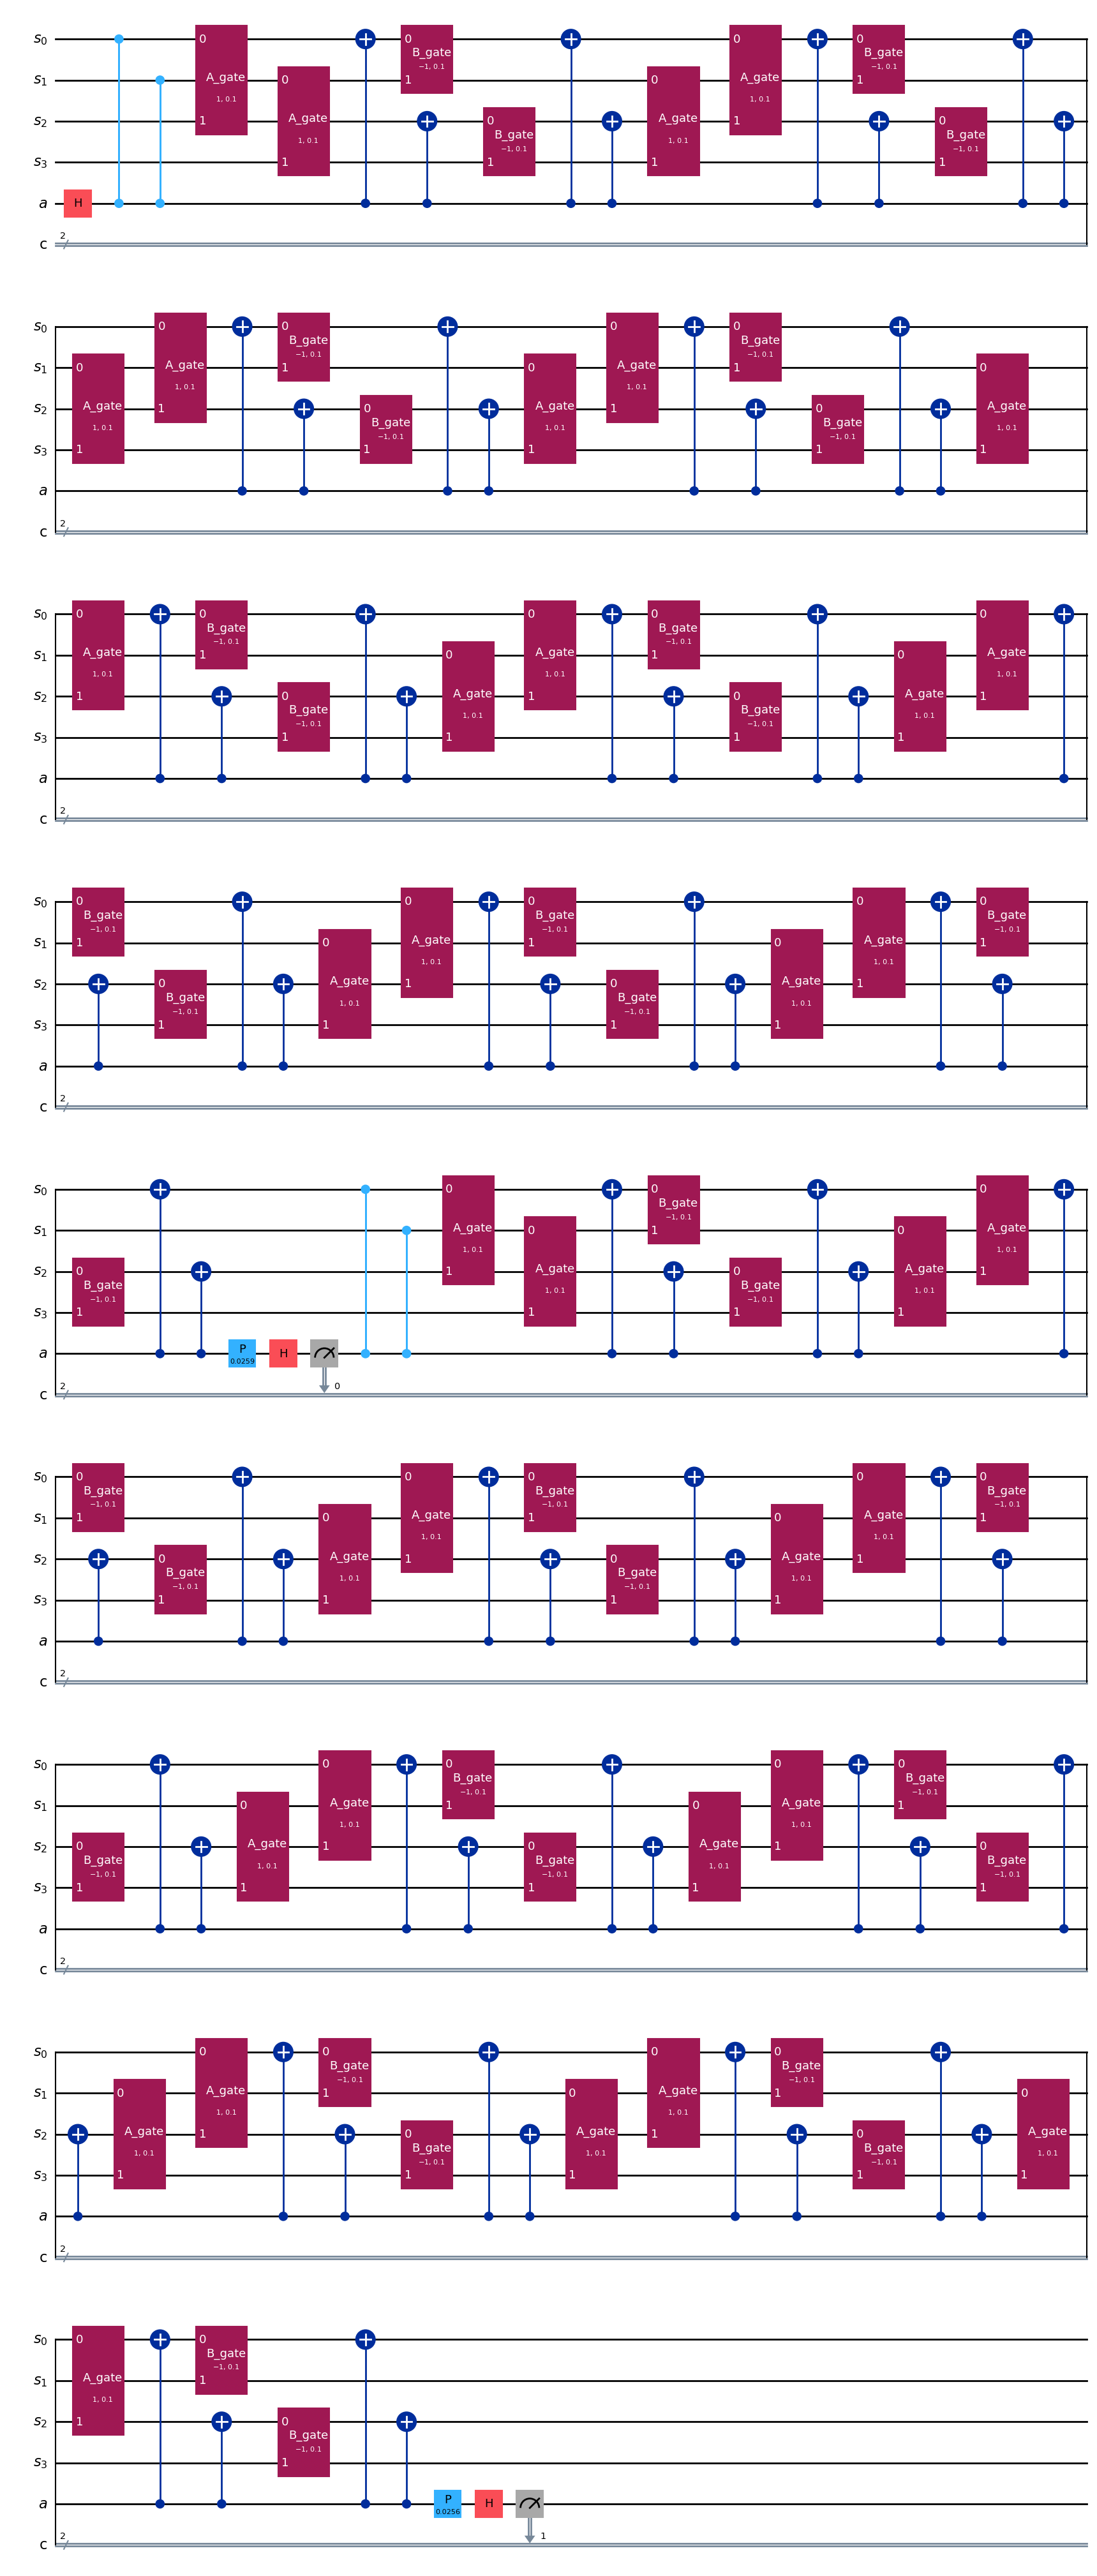

In [8]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter

# Define global parameters for hopping and on-site interactions
J = Parameter('J')
U = Parameter('U')
dt = Parameter('dt')

# Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate():
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')
    
    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * dt) / 2, 0)
    hop_circ.ry((-1 * J * dt) / 2, 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label="A_gate")

A_gate = create_hopping_gate()

# On-site interaction gate
def create_onsite_gate():
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.ry(2 * U * dt, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label="B_gate")

B_gate = create_onsite_gate()

# Combined function for the Trotter evolution with auxiliary control and measurement
def rodeo_circuit(J_value, U_value, delta_t, total_t, num_sites, cycles, targ, gamma_input):
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)
    num_steps = int(total_t // delta_t)  # Calculate the number of Trotter steps
    E_targ = Parameter('E')  # Target energy parameter
    t_params = [Parameter(f't_{i}') for i in range(cycles)]
    
    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    classical = ClassicalRegister(cycles, 'c')
    circuit = QuantumCircuit(sys, aux, classical)
    
    # Apply Hadamard on the auxiliary qubit
    circuit.h(aux)

    # Build the Trotter evolution with randomized time samples per cycle
    for cycle in range(cycles):
        circuit.cz([sys[0], sys[1]], aux)
        # Generate random time samples for the current cycle based on gamma
        time_samples = (1 / gamma_input) * np.random.randn(num_steps)

        for step in range(num_steps):
            # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
            for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
                spin_up_qubit_1 = site * 2
                spin_up_qubit_2 = (site + 1) * 2
                circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

            for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
                spin_up_qubit_1 = site * 2
                spin_up_qubit_2 = (site + 1) * 2
                circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

            # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
            for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
                spin_down_qubit_1 = site * 2 + 1
                spin_down_qubit_2 = (site + 1) * 2 + 1
                circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

            for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
                spin_down_qubit_1 = site * 2 + 1
                spin_down_qubit_2 = (site + 1) * 2 + 1
                circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

            # Add CX gates for every two system qubits
            for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
                circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
                if i + 2 < num_qubits:        # Ensure we're within bounds
                    circuit.cx(aux, sys[i + 2])

            # Apply B_gate for on-site interactions on each site
            for site in range(num_sites):
                spin_up_qubit = site * 2
                spin_down_qubit = site * 2 + 1
                circuit.append(B_gate, [spin_up_qubit, spin_down_qubit])

            # Add CX gates for every two system qubits
            for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
                circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
                if i + 2 < num_qubits:        # Ensure we're within bounds
                    circuit.cx(aux, sys[i + 2])

        # Apply phase rotation and Hadamard on auxiliary qubit
        circuit.p(E_targ * t_params[cycle], aux)
        circuit.h(aux)
        circuit.measure(aux, classical[cycle])
    
    # Assign parameters to the circuit
    time_binds = dict(zip(t_params, time_samples))
    parameter_binds = {J: J_value, U: U_value, E_targ: targ, dt: delta_t}
    final_circuit = circuit.assign_parameters({**time_binds, **parameter_binds}, inplace=False)
    
    return final_circuit

# Example usage
E_targ = 0.2
dt_val = 0.1
total_time = 1.0
num_sites = 2
num_cycles = 2
gamma_input = 0.5

circuit = rodeo_circuit(
    J_value=1, U_value=-1, delta_t=dt_val, total_t=total_time, 
    num_sites=num_sites, cycles=num_cycles, targ=2 * E_targ * dt_val * total_time, 
    gamma_input=gamma_input
)

circuit.draw('mpl')


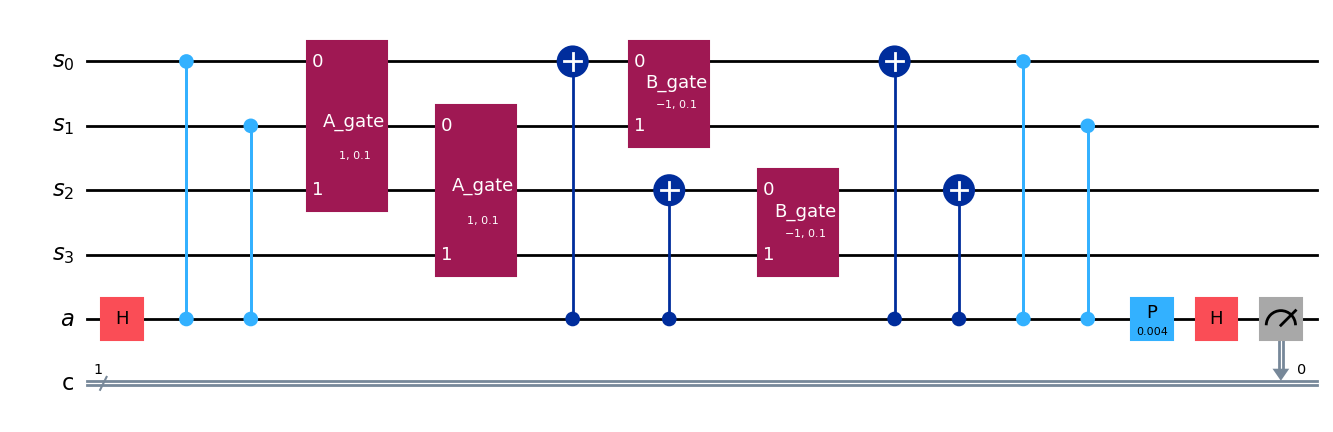

In [4]:
circuit.draw('mpl')

In [ ]:
# Enumerate scan energies
energymin = -8
energymax = 1
stepsize = 0.01

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))
targetenergynum = len(targetenergies)
print("Number of target energies:", targetenergynum)

#Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter
gamma = 0.1

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 1024

# Create empty list for data
data = []

E_targ = 0.2
dt = 0.1
num_cycles = 3

# Loop through energy list
for i in range(len(targetenergies)):
    
    # Creates dictionary for target energy parameter
    targ_energy = {E_targ : targetenergies[i]}

    # Below is a troubleshooting line you can use to see if the code is scanning through energies properly
    print("Executing for Target Energy:", targ_energy)
    
    # Initialize a list that will contain the results of all 10 resamples for 1 target energy
    targetenergyrun = []
    for _ in range(timeresamples):
        # Creates random time samples for 1 run
        # tsamples = ((1 / gamma) * np.random.randn(num_cycles)).tolist()
        # trottersteps = tsamples//dt
        tsample = ((1 / gamma) * np.random.randn(num_cycles))
        trottersteps = tsample//dt
        
        
        # Creates a dictionary to be able to bind time samples to time parameters

        circuit = rodeo_circuit(J_value = 1,U_value = -1,delta_t = dt,num_steps = trottersteps,
                                num_sites = 2,cycles = num_cycles,targ = 2*E_targ*dt*trottersteps)
        time_parameter_binds = zip(t, tsamples)
        time_parameters = dict(time_parameter_binds)
        
        # Assigns target energy and time values to parameters
        circuit1 = circuit.assign_parameters(time_parameters, inplace =False)
        circuit2 = circuit1.assign_parameters(targ_energy, inplace = False)
        
        # Runs simulation of circuit with values
        sampler = Sampler()
        job = sampler.run(circuit2)
        job.result()
        quasi_dists = job.result().quasi_dists
        
        # Appends the results to list for this target energy
        targetenergyrun.append(quasi_dists)
    
    # The output from above needs to be post-processed as shown below to gain meaning from it:

    # Flattens list of list of dictionaries into just a list of dictionaries
    flattened_list = []
    for sublist in targetenergyrun:
        flattened_list.extend(sublist)

    # Sums and average dictionaries from multiple timeresamples
    combined_dict = {} 
    for dictionary in flattened_list:
        for key, value in dictionary.items():
            combined_dict[key] = combined_dict.get(key, 0) + value

    average_dict = {}
    for key in combined_dict:
        average_dict[key] = combined_dict[key] / timeresamples

    data.append(average_dict)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# This extracts the probabilities for the 0 bitcounts from our obtained data
values_list = []
for d in data:
    if 0 in d:
        values_list.append(d[0])
    else:
        values_list.append(0.0)
print(len(values_list))
print(len(targetenergies))

# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# # initial_guess = [
# #     1, 0,1

# # ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

# # Plot the data and the fit
# plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
# plt.grid()
# plt.xlabel('Target Energy')
# plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
# # plt.axvline(x = -0.44, color = 'green', label = 'Ground Energy', linestyle = '--')

# plt.legend()
# plt.show()

# # Print the peaks (centers) of the Gaussians
# # n_gaussians = len(fitted_params) // 3
# # peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# # print(f'The peaks (centers) of the Gaussians are at: {peaks}')


In [6]:
gamma = 2
num_cycles = 3
import numpy as np
((1 / gamma) * np.random.randn(num_cycles))

array([-0.41570076, -0.04538896,  0.41461695])

In [1]:
# As of July 22, 2024, most recent code for simulating AQC on qiskit QCs.
# Uses a trotterization, and able to provide <E> after simulating.

from qiskit import QuantumCircuit
from tqdm import tqdm
import sys
from qiskit.primitives import BackendSampler as BackendSampler
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib as mpl
from qiskit.primitives import StatevectorEstimator as SEstimator
from qiskit.result import sampled_expectation_value

# Perform an arbitrary unitary operation on two qubits
# of the form N = exp(i(alpha sx x sx + beta sy x sy + gamma sz x sz) dt)
def full_N(q_c, bits, J, dt):
    alpha = J[0]
    beta = J[1]
    gamma = J[2]

    alpha *= dt
    beta *= dt
    gamma *= dt
    
    b0 = bits[0]
    b1 = bits[1]


    theta = np.pi/2 - 2*gamma
    phi = 2*alpha - np.pi/2
    lambd = np.pi/2 - 2*beta

    q_c.rz(-np.pi/2, b1)
    q_c.cx(b1, b0)
    q_c.rz(theta, b0)
    q_c.ry(phi, b1)
    q_c.cx(b0, b1)
    q_c.ry(lambd, b1)
    q_c.cx(b1, b0)
    q_c.rz(np.pi/2, b0)

"""
For later use when reducing two two CNOTS 
Consider using the U gate provided by qiskit

def simplified_N(q_c, bits, alpha, gamma):
    b0 = bits[0]
    b1 = bits[1]

    q_c.cx(b0, b1)
    q_c.rx(-2*alpha, b0)
    q_c.rz(-2*gamma, b1)
    q_c.cx(b0, b1)
"""

"""
final_hamiltonian_entries = []
for i in range(SIZE):
    string_of_ops = "I"*i+"Z"+"I"*(SIZE-i-1)
    if CONSTANT_H != 0:
        final_hamiltonian_entries.append((string_of_ops,-CONSTANT_H))

for i in range(SIZE-1):
    string_of_ops_X = "I"*i + "XX" + "I"*(SIZE-i-2)
    string_of_ops_Y = "I"*i + "YY" + "I"*(SIZE-i-2)
    string_of_ops_Z = "I"*i + "ZZ" + "I"*(SIZE-i-2)
    if J[0] != 0:
        final_hamiltonian_entries.append((string_of_ops_X,-J[0]))
    if J[1] != 0:
        final_hamiltonian_entries.append((string_of_ops_Y,-J[1]))
    if J[2] != 0:
        final_hamiltonian_entries.append((string_of_ops_Z,-J[2]))

final_hamiltonian = SparsePauliOp.from_list(final_hamiltonian_entries)
"""

#size = 4
#J = [-1,0,0]
#h = 2
#full_final = spin_chain_improved.recursive_hamiltonian_sparse(size, J, h)
#full_final = spin_chain_improved.connected_chain_hamiltonian(size, J, h)
##full_final = full_final.toarray()
#final_hamiltonian = SparsePauliOp.from_operator(Operator(full_final))
#print(final_hamiltonian)
#print("remove sys.exit() to continue")
#sys.exit()

# Time evolve a given bit for time dt with magnetic field strength h pointing on z axis.
def magnetic_ev(q_c, bits, h, dt):
    q_c.rz(2*dt*h,bits)

# Convert a state (ordered in reverse) to full N^2 state vector
def convert_to_statevec(state):
    res = 0
    if state[-1] == "0":
        res = [1,0]
    else:
        res = [0,1]

    for i in range(len(state)-2,-1,-1):
        if state[i] == "0":
            res = np.kron(res, [1,0])
        else:
            res = np.kron(res, [0,1])

    print(res)
    return res

# returns <observable> = <state|observable|state>
def expectation_value(observable, state):
    return state.conj() @ (observable @ state)


def adiabatic_evolution(size, show_circuit, total_time, trotter_steps, J, H, backend, shots):
    dt = total_time/trotter_steps

    #full_final = spin_chain_improved.recursive_hamiltonian_sparse(size, J, H)
    #full_final = full_final.toarray()
    #final_hamiltonian = SparsePauliOp.from_operator(Operator(full_final))
    final_hamiltonian_entries = []
    for i in range(SIZE):
        string_of_ops = "I"*i+"Z"+"I"*(SIZE-i-1)
        if CONSTANT_H != 0:
            final_hamiltonian_entries.append((string_of_ops,-CONSTANT_H))

    for i in range(SIZE-1):
        string_of_ops_X = "I"*i + "XX" + "I"*(SIZE-i-2)
        string_of_ops_Y = "I"*i + "YY" + "I"*(SIZE-i-2)
        string_of_ops_Z = "I"*i + "ZZ" + "I"*(SIZE-i-2)
        if J[0] != 0:
            final_hamiltonian_entries.append((string_of_ops_X,-J[0]))
        if J[1] != 0:
            final_hamiltonian_entries.append((string_of_ops_Y,-J[1]))
        if J[2] != 0:
            final_hamiltonian_entries.append((string_of_ops_Z,-J[2]))

    final_hamiltonian_entries.append(("X" + "I"*(SIZE-2) + "X", -J[0]))
    final_hamiltonian_entries.append(("Y" + "I"*(SIZE-2) + "Y", -J[1]))
    final_hamiltonian_entries.append(("Z" + "I"*(SIZE-2) + "Z", -J[2]))

    final_hamiltonian = SparsePauliOp.from_list(final_hamiltonian_entries)
    print(final_hamiltonian)

    qc = QuantumCircuit(size,size)


    # Initial state preparation, default to |0>,
    # apply X to set to |1>
    #qc.x(0)
    #qc.x(1)
    #qc.x(2)
    #qc.x(3)

    # Actual adiabatic evolution procedure
    """
    for s in tqdm(np.linspace(0,1,trotter_steps)):
        # TODO
        # Figure out why we need to include the -1 coefficient in from of the J
        # This might be due to a typo in the paper that presented the N gate?
        #full_N(qc, [0,1], -1*np.array(J), dt)
        #full_N(qc, [1,2], -1*s*np.array(J), dt)
        #full_N(qc, [2,3], -1*np.array(J), dt)
        for i in range(size):
            if i % 2 == 0:
                full_N(qc, [i,i+1], -1*np.array(J), dt)
            else:
                try:
                    full_N(qc, [i,i+1], -1*s*np.array(J), dt)
                    print(i,i+1)
                except:
                    full_N(qc, [i,0], -1*s*np.array(J), dt)
                    #print("errored")
                    #print(i,0)


        # Magnetically evolve all qubits
        for bit_num in range(size):
            magnetic_ev(qc, bit_num, H, dt)
    """

    if show_circuit:
        qc.draw(output="mpl")
        plt.show()


    # Transpilation
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

    isa_circuit = pm.run(qc)

    isa_observables = final_hamiltonian.apply_layout(isa_circuit.layout)

    estimator = BackendEstimator(backend = backend)
    estimator.options.default_shots = shots

    
    # calculate [ <psi|hamiltonian|psi> ]
    print("Running!")
    job = estimator.run([(isa_circuit, isa_observables)])

    print(job.result())
    pub_result = job.result()[0]
    return pub_result.data.evs

if __name__ == "__main__":
    SIZE = 70 # Number of qubits
    SHOW_CIRCUIT = False
    TOTAL_TIME = 1      
    TROTTER_STEPS = 5
    D_TIME = TOTAL_TIME/TROTTER_STEPS 
    CONSTANT_H = 2
    J_MAG = [-1,0,0]
    SHOTS = 2048

    service = QiskitRuntimeService()
    #BACKEND = service.least_busy(operational=True, simulator=False, min_num_qubits=10)
    #BACKEND = FakeAlmadenV2()
    #BACKEND = FakeLagosV2()
    #BACKEND = AerSimulator() # gives no noise, only statistical error associated with making measurements on quantum states.
    BACKEND = AerSimulator(method='matrix_product_state') # gives no noise, only statistical error associated with making measurements on quantum states.

    energy_expectation_value = adiabatic_evolution(SIZE, SHOW_CIRCUIT, TOTAL_TIME, TROTTER_STEPS, J_MAG, CONSTANT_H, BACKEND, SHOTS)
    print(f"Calculated <E> on {BACKEND}: {energy_expectation_value}")





"""
############################# OLD CODE USING SAMPLER BELOW

qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)
qc.measure(3,3)
isa_circuit = pm.run(qc)

sampler = BackendSampler(backend = BACKEND)

job = sampler.run([isa_circuit],shots=SHOTS)
print(f"Job: {job.job_id()}     Status: {job.status()}")

result = job.result()

#print(f"!!!! {sampled_expectation_value(result.quasi_dists[0],final_hamiltonian)}")
#TODO: REMOVE HERE EXIT


dict_of_res = result.quasi_dists[0].binary_probabilities() #[0]
full_statevector = np.array([0]*SIZE**2, dtype=float)
for keyy in dict_of_res.keys():
    ## FIX HERE
    # how to make sure that the revlative phase is not lost?
    full_statevector += convert_to_statevec(keyy) * np.sqrt(dict_of_res[keyy])


print(full_statevector)

# probability of measuring 1 for each qubit, ordered in reverse ie [-1] = qubit 0
#prob_of_one = [0]*SIZE
#for i in range(SIZE):
#    for keyy in dict_of_res.keys():
#        if keyy[i] == "1":
#            prob_of_one[i] += dict_of_res[keyy]
#
#individual_states = []
#for prob in reversed(prob_of_one):
#    c0 = np.sqrt(prob)
#    c1 = np.sqrt(1-prob)
#    individual_states.append([c0, c1])
#
#final_statevector = individual_states[0] 
#for individual_state in individual_states[1:]:
#    final_statevector = np.kron(final_statevector, individual_state)
#
#print(final_statevector)
    
print(f"Counts for the meas output register: {dict_of_res}")
plt.bar(dict_of_res.keys(), dict_of_res.values(), 1, color='g')
plt.show()
if False:
    print("\n"*10)



    gened_hams = trotterization_exact.generate_initial_and_final_hamiltonians([2,2], J, CONSTANT_H)
    for a in gened_hams:
        print(a.toarray())
        import scipy
        print(scipy.sparse.linalg.eigsh(a))
        print(trotterization_exact.minimal_eigenvector(a))


    print("Calculating overlap: ")
    print(gened_hams[0])

    test_state = convert_to_statevec("0000")
    print(f"ground state overlap {np.matmul(test_state.conj(), (gened_hams[0] @ test_state))} ")
        
    test_2 = spin_chain_improved.recursive_hamiltonian_sparse(2, J, 3)
    print(test_2.toarray())
    import scipy
    print(scipy.linalg.eigh(test_2.toarray()))

    print("\n"*10)

# calculting the expectation value of the hamiltonian 
# based on the actual matrix representation

full_final = spin_chain_improved.recursive_hamiltonian_sparse(SIZE, J, CONSTANT_H)
full_final = full_final.toarray()
#print(full_final)
import scipy
#print(scipy.linalg.eigh(full_final))
test_state = full_statevector
print(full_final)
print(f"resulting state: {test_state}")
#print(f"<E> {expectation_value(full_final, test_state)}")
"""

"""
# Experiemntal...
#
# 99% does not work
list_to_sum = []
for key in dict_of_res:
    converted_s = convert_to_statevec(key)
    energy_exp_single = expectation_value(full_final, converted_s)
    print(f"Energy: {int(energy_exp_single)}")

    list_to_sum.append(dict_of_res[key]/SHOTS * energy_exp_single)

print(f"Expectation value of energy: {sum(list_to_sum)}")
"""
"""
final_hamiltonian_entries = []
for i in range(SIZE):
    string_of_ops = "I"*i+"Z"+"I"*(SIZE-i-1)
    if CONSTANT_H != 0:
        final_hamiltonian_entries.append((string_of_ops,-CONSTANT_H))

for i in range(SIZE-1):
    string_of_ops_X = "I"*i + "XX" + "I"*(SIZE-i-2)
    string_of_ops_Y = "I"*i + "YY" + "I"*(SIZE-i-2)
    string_of_ops_Z = "I"*i + "ZZ" + "I"*(SIZE-i-2)
    if J[0] != 0:
        final_hamiltonian_entries.append((string_of_ops_X,-J[0]))
    if J[1] != 0:
        final_hamiltonian_entries.append((string_of_ops_Y,-J[1]))
    if J[2] != 0:
        final_hamiltonian_entries.append((string_of_ops_Z,-J[2]))

final_hamiltonian = SparsePauliOp.from_list(final_hamiltonian_entries)
print(final_hamiltonian)







ModuleNotFoundError: No module named 'qiskit_aer.quantum_info.states.aer_state'

In [13]:
from qiskit.quantum_info import SparsePauliOp

def fermi_hubbard_hamiltonian(SIZE, J_hopping, U_onsite):
    """
    Constructs the Fermi-Hubbard Hamiltonian with nearest-neighbor hopping (XX and YY) terms and
    on-site interaction (ZZ) terms for a system of given SIZE.
    
    SIZE : int
        The number of sites in the chain. Each site has two qubits (up and down spin).
    J_hopping : float
        The strength of the nearest-neighbor hopping interaction.
    U_onsite : float
        The strength of the on-site interaction.
    
    Returns:
    SparsePauliOp
        The Hamiltonian as a SparsePauliOp.
    """
    # Define terms for the Hamiltonian
    hamiltonian_entries = []
    num_qubits = SIZE * 2  # Total number of qubits

    # Nearest-Neighbor Hopping Terms (XX and YY between up spins and between down spins)
    for site in range(SIZE - 1):
        # Indices for up-spin and down-spin qubits on the current and next site
        up_spin_qubit_1 = site * 2
        down_spin_qubit_1 = site * 2 + 1
        up_spin_qubit_2 = (site + 1) * 2
        down_spin_qubit_2 = (site + 1) * 2 + 1
        
        # XX interaction between nearest-neighbor up spins
        xx_up_term = ["I"] * num_qubits
        xx_up_term[up_spin_qubit_1] = "X"
        xx_up_term[up_spin_qubit_2] = "X"
        hamiltonian_entries.append(("".join(xx_up_term), -J_hopping))
        
        # YY interaction between nearest-neighbor up spins
        yy_up_term = ["I"] * num_qubits
        yy_up_term[up_spin_qubit_1] = "Y"
        yy_up_term[up_spin_qubit_2] = "Y"
        hamiltonian_entries.append(("".join(yy_up_term), -J_hopping))
        
        # XX interaction between nearest-neighbor down spins
        xx_down_term = ["I"] * num_qubits
        xx_down_term[down_spin_qubit_1] = "X"
        xx_down_term[down_spin_qubit_2] = "X"
        hamiltonian_entries.append(("".join(xx_down_term), -J_hopping))
        
        # YY interaction between nearest-neighbor down spins
        yy_down_term = ["I"] * num_qubits
        yy_down_term[down_spin_qubit_1] = "Y"
        yy_down_term[down_spin_qubit_2] = "Y"
        hamiltonian_entries.append(("".join(yy_down_term), -J_hopping))
    
    # On-Site Interaction Terms (ZZ within each site between up and down spins)
    for site in range(SIZE):
        # Indices for up-spin and down-spin qubits on the current site
        up_spin_qubit = site * 2
        down_spin_qubit = site * 2 + 1
        
        # ZZ interaction within each site
        zz_onsite_term = ["I"] * num_qubits
        zz_onsite_term[up_spin_qubit] = "Z"
        zz_onsite_term[down_spin_qubit] = "Z"
        hamiltonian_entries.append(("".join(zz_onsite_term), U_onsite))
    
    # Create the Hamiltonian as a SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(hamiltonian_entries)
    
    return hamiltonian

# Example usage
SIZE = 4  # Number of sites
J_hopping = 1.0  # Hopping term coefficient
U_onsite = 2.0  # On-site interaction term coefficient

hamiltonian = fermi_hubbard_hamiltonian(SIZE, J_hopping, U_onsite)
print("Fermi-Hubbard Hamiltonian:")
print(hamiltonian)


Fermi-Hubbard Hamiltonian:
SparsePauliOp(['XIXIIIII', 'YIYIIIII', 'IXIXIIII', 'IYIYIIII', 'IIXIXIII', 'IIYIYIII', 'IIIXIXII', 'IIIYIYII', 'IIIIXIXI', 'IIIIYIYI', 'IIIIIXIX', 'IIIIIYIY', 'ZZIIIIII', 'IIZZIIII', 'IIIIZZII', 'IIIIIIZZ'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j,
 -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j,  2.+0.j,  2.+0.j,  2.+0.j,  2.+0.j])


In [ ]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import Parameter

# # Define global parameters for hopping and on-site interactions
# J = Parameter('J')
# U = Parameter('U')
# dt = Parameter('dt')

# Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate(delta_t, J):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')
    
    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t) / 2, 0)
    hop_circ.ry((-1 * J * delta_t) / 2, 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label="A_gate")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.ry(2 * U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label="B_gate")


# Function for a single Rodeo cycle with Trotter evolution and auxiliary qubit control
def rodeo_cycle(J_value, U_value, delta_t, num_sites, E_target, gamma_input):
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)
    time_sample = (1 / gamma_input) * np.random.randn()
    num_steps = int(time_sample // delta_t)  # Number of Trotter steps within this cycle
    phase_t = Parameter('phase_t')  # Phase parameter for the auxiliary qubit rotation

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    circuit = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    circuit.h(aux)
    circuit.cz([sys[0], sys[1]], aux)

    # Trotter evolution within this single Rodeo cycle
    for step in range(num_steps):
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # Add CX gates for every two system qubits
        for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
            circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
            if i + 2 < num_qubits:        # Ensure we're within bounds
                circuit.cx(aux, sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            circuit.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # Add CX gates for every two system qubits
        for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
            circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
            if i + 2 < num_qubits:        # Ensure we're within bounds
                circuit.cx(aux, sys[i + 2])

    # Phase rotation based on the energy target and time sample
    circuit.cz([sys[0], sys[1]], aux)
    circuit.p(E_target * phase_t, aux)
    circuit.h(aux)

    # Assign parameters to the circuit
    parameter_binds = {J: J_value, U: U_value, dt: delta_t, phase_t: time_sample}
    final_circuit = circuit.assign_parameters(parameter_binds, inplace=False)

     # Convert the fully parameterized circuit into a gate with a dynamic label
    gate_label = f"Rodeo_{time_sample:.3f}_Evolution"
    rodeo_gate = final_circuit.to_gate(label=gate_label)
    
    return rodeo_gate

# Example usage of a single Rodeo cycle as a gate
E_target = 0.2
dt_val = 0.1
num_sites = 2
gamma_input = 0.5

rodeo_gate = rodeo_cycle(
    J_value=1, U_value=-1, delta_t=dt_val, num_sites=num_sites, 
    E_target=E_target, gamma_input=gamma_input
)

# Create a new circuit to add the Rodeo gate
test_circuit = QuantumCircuit(num_sites * 2 + 1)
test_circuit.append(rodeo_gate, range(num_sites * 2 + 1))
test_circuit.draw('mpl')

#     return final_circuit
# # Example usage of a single Rodeo cycle
# E_target = 0.2
# dt_val = 0.1
# num_sites = 2
# gamma_input = 0.5

# cycle_circuit = rodeo_cycle(
#     J_value=1, U_value=-1, delta_t=dt_val, num_sites=num_sites, 
#     E_target=E_target, gamma_input=gamma_input
# )




In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate

def create_hopping_gate(delta_t, J):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')
    
    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t) / 2, 0)
    hop_circ.ry((-1 * J * delta_t) / 2, 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label="A_gate")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.ry(2 * U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label="B_gate")

def rodeo_cycle(num_sites, J_value, U_value, t: Parameter, r, targ: Parameter):
    beta = t / r # Parameter for rotation gates
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)
    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    circuit.h(aux)
    circuit.cz([sys[0], sys[1]], aux)

    # Trotter evolution within this single Rodeo cycle
    # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
    A_gate = create_hopping_gate(delta_t = beta, J = J_value)
    for _ in range(r):
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            circuit.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            circuit.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # Add CX gates for every two system qubits
        for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
            circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
            if i + 2 < num_qubits:        # Ensure we're within bounds
                circuit.cx(aux, sys[i + 2])

        B_gate = create_onsite_gate(U = U_value, delta_t = beta)

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            circuit.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # Add CX gates for every two system qubits
        for i in range(0, num_qubits, 4):  # Adjust the step to 4 to apply to every other pair
            circuit.cx(aux, sys[i])       # Controlled X on selected system qubits
            if i + 2 < num_qubits:        # Ensure we're within bounds
                circuit.cx(aux, sys[i + 2])

    # Phase rotation based on the energy target and time sample
    circuit.cz([sys[0], sys[1]], aux)
    circuit.p(2*targ * t, aux)
    circuit.h(aux)

    # Assign parameters to the circuit
    return circuit

# Parameters
num_sites = 2
J_input = 1
U_input = 1
hz = -0.5 * 0.5 * 2 * np.pi
numqubits = 2*num_sites
cycles = 3

# Initialize system parameters
timeresamples = 10

# Create Target and t parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
r = 5

# Create a list of target energies at the same length of the cycle
targ_list = [target] * cycles

# Create registers and circuit
classical = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(numqubits, 's')
circuit = QuantumCircuit(classical, sys, aux)

for i in range(numqubits):
    circuit.h(i)

# for i in range(numqubits):
#     circuit.x(i)

# Create circuit
for j in range(cycles):
    circuit.append(rodeo_cycle(num_sites=2, J_value = J_input, U_value = U_input, t = time[j], r =4, 
                               targ = target ), range(1 + numqubits))
    circuit.measure(aux, classical[j])

circuit.draw(output='mpl')


CircuitError: 'The amount of clbit arguments 0 does not match the instruction expectation (3).'

$t_0$/5
$t_1$/5
$t_2$/5


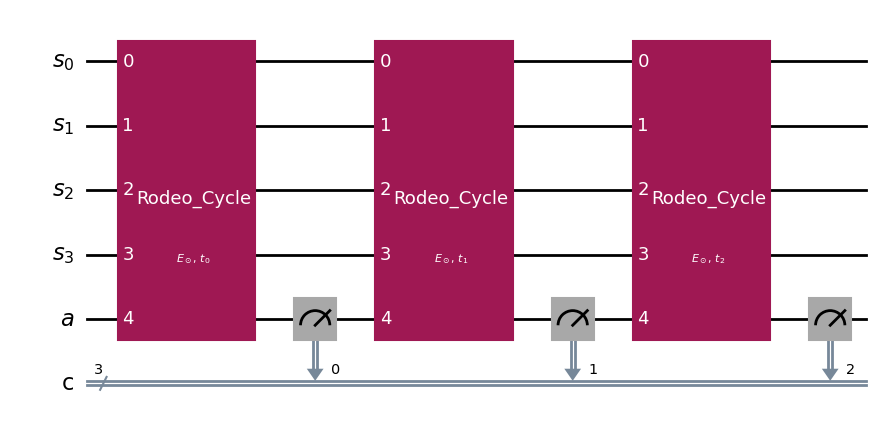

In [12]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

# # Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')
    
    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t) / 2, 0)
    hop_circ.ry((-1 * J * delta_t) / 2, 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.ry(2 * U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label=fr"B_gate_{U}")

# Define the rodeo cycle
def rodeo_cycle(num_sites, J_value, U_value, t: Parameter, r, targ: Parameter):
    beta = t / r  # Parameter for rotation gates
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    qc.h(aux[0])
    qc.cz([sys[0], sys[1]], aux[0])

    # Trotter evolution within this single Rodeo cycle
    A_gate = create_hopping_gate(J=J_value, delta_t=beta)
    B_gate = create_onsite_gate(U=U_value, delta_t=beta)

    for _ in range(r):
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # Add CX gates for every other system qubit
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            qc.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # Add CX gates for every other system qubit again
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])

    qc.cz([sys[0], sys[1]], aux[0])
    # Phase rotation based on the energy target and time sample
    qc.p(2 * targ * t, aux[0])
    qc.h(aux[0])

    return qc, beta

# Define parameters
num_sites = 2
J_input = -1
U_input = 1
cycles = 3

# Initialize system parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
steps = 5

# Create a list of target energies at the same length of the cycle
targ_list = [target] * cycles

# Create registers and circuit
classical = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

# Create circuit with rodeo cycles
for j in range(cycles):
    rodeo_gate, dt_val = rodeo_cycle(num_sites=2, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label = fr'Rodeo_Cycle'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[j])  # Ensure that the measurement of `aux` qubit is mapped to the `j`-th classical bit
    print(dt_val)
    

circuit.draw('mpl')


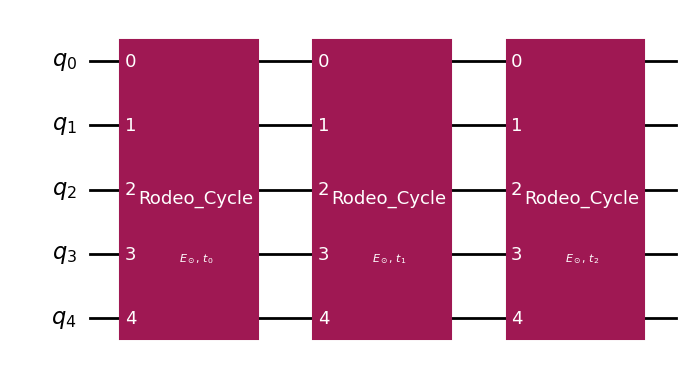

In [11]:
circuit = QuantumCircuit(5)
for j in range(cycles):
    rodeo_gate = rodeo_cycle(num_sites=2, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label = fr'Rodeo_Cycle'), range(num_sites * 2 + 1))
circuit.draw('mpl')

In [ ]:
from qiskit_aer.primitives import Sampler
timeresamples = 10
gamma = 2
for _ in range(timeresamples):
    tsamples = ((1 / gamma) * np.abs(np.random.randn(cycles))).tolist()
    #parameter_binds.append({t[i]: tsamples[i] for i in range(cycles)})
    
parameter_binds = zip(time, tsamples)
parameters = dict(parameter_binds)

target = {target : -6.28}
    
circuit1 = circuit.assign_parameters(parameters, inplace =False)
circuit2 = circuit1.assign_parameters(target, inplace = False)
circuit2.draw(output= 'mpl')

CircuitError: 'Cannot bind parameters ($t_0$, $t_1$) not present in the circuit.'

In [3]:
sampler = Sampler()

job = sampler.run(circuit2)

job.result()

quasi_dists = job.result().quasi_dists

print(quasi_dists)

[{5: 0.4267578125, 1: 0.2021484375, 7: 0.0986328125, 4: 0.0146484375, 2: 0.103515625, 3: 0.1181640625, 0: 0.0068359375, 6: 0.029296875}]


In [ ]:
circuit.draw('mpl')

NameError: name 'circuit2' is not defined

Number of target energies: 32
Executing for Target Energy: {Parameter($E_\odot$): -16.0}
Executing for Target Energy: {Parameter($E_\odot$): -14.967741935483872}
Executing for Target Energy: {Parameter($E_\odot$): -13.935483870967742}
Executing for Target Energy: {Parameter($E_\odot$): -12.903225806451612}
Executing for Target Energy: {Parameter($E_\odot$): -11.870967741935484}
Executing for Target Energy: {Parameter($E_\odot$): -10.838709677419356}
Executing for Target Energy: {Parameter($E_\odot$): -9.806451612903226}
Executing for Target Energy: {Parameter($E_\odot$): -8.774193548387096}
Executing for Target Energy: {Parameter($E_\odot$): -7.741935483870968}
Executing for Target Energy: {Parameter($E_\odot$): -6.70967741935484}
Executing for Target Energy: {Parameter($E_\odot$): -5.67741935483871}
Executing for Target Energy: {Parameter($E_\odot$): -4.64516129032258}
Executing for Target Energy: {Parameter($E_\odot$): -3.612903225806452}
Executing for Target Energy: {Parameter($E_\o

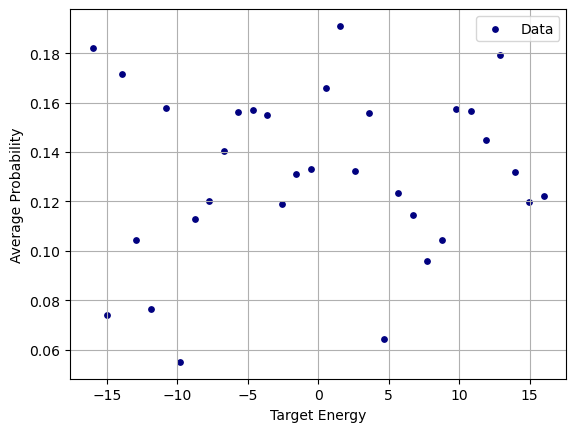

In [3]:
from qiskit_aer.primitives import Sampler
# Enumerate scan energies
energymin = -16
energymax = 16
stepsize = 1

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))
targetenergynum = len(targetenergies)
print("Number of target energies:", targetenergynum)

#Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter
gamma = 0.1

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 1024

# Create empty list for data
data = []

# Loop through energy list
for i in range(len(targetenergies)):
    
    # Creates dictionary for target energy parameter
    targ_energy = {target : targetenergies[i]}

    # Below is a troubleshooting line you can use to see if the code is scanning through energies properly
    print("Executing for Target Energy:", targ_energy)
    
    # Initialize a list that will contain the results of all 10 resamples for 1 target energy
    targetenergyrun = []
    for _ in range(timeresamples):
        # Creates random time samples for 1 run
        tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()
        
        # Creates a dictionary to be able to bind time samples to time parameters
        time_parameter_binds = zip(time, tsamples)
        time_parameters = dict(time_parameter_binds)
        
        # Assigns target energy and time values to parameters
        circuit1 = circuit.assign_parameters(time_parameters, inplace =False)
        circuit2 = circuit1.assign_parameters(targ_energy, inplace = False)
        
        # Runs simulation of circuit with values
        sampler = Sampler()
        job = sampler.run(circuit2)
        job.result()
        quasi_dists = job.result().quasi_dists
        
        # Appends the results to list for this target energy
        targetenergyrun.append(quasi_dists)
    
    # The output from above needs to be post-processed as shown below to gain meaning from it:

    # Flattens list of list of dictionaries into just a list of dictionaries
    flattened_list = []
    for sublist in targetenergyrun:
        flattened_list.extend(sublist)

    # Sums and average dictionaries from multiple timeresamples
    combined_dict = {} 
    for dictionary in flattened_list:
        for key, value in dictionary.items():
            combined_dict[key] = combined_dict.get(key, 0) + value

    average_dict = {}
    for key in combined_dict:
        average_dict[key] = combined_dict[key] / timeresamples

    data.append(average_dict)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# This extracts the probabilities for the 0 bitcounts from our obtained data
values_list = []
for d in data:
    if 0 in d:
        values_list.append(d[0])
    else:
        values_list.append(0.0)
print(len(values_list))
print(len(targetenergies))

# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
# plt.axvline(x = -0.44, color = 'green', label = 'Ground Energy', linestyle = '--')

plt.legend()
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')


In [4]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.algorithms import NumPyEigensolver

# Define the function to create the Fermi-Hubbard Hamiltonian (use your provided function)
def fermi_hubbard_hamiltonian(SIZE, J_hopping, U_onsite):
    hamiltonian_entries = []
    num_qubits = SIZE * 2  # Total number of qubits

    # Nearest-Neighbor Hopping Terms (XX and YY between up spins and down spins)
    for site in range(SIZE - 1):
        up_spin_qubit_1 = site * 2
        down_spin_qubit_1 = site * 2 + 1
        up_spin_qubit_2 = (site + 1) * 2
        down_spin_qubit_2 = (site + 1) * 2 + 1

        # XX interaction for up spins
        xx_up_term = ["I"] * num_qubits
        xx_up_term[up_spin_qubit_1] = "X"
        xx_up_term[up_spin_qubit_2] = "X"
        hamiltonian_entries.append(("".join(xx_up_term), -J_hopping))
        
        # YY interaction for up spins
        yy_up_term = ["I"] * num_qubits
        yy_up_term[up_spin_qubit_1] = "Y"
        yy_up_term[up_spin_qubit_2] = "Y"
        hamiltonian_entries.append(("".join(yy_up_term), -J_hopping))
        
        # XX interaction for down spins
        xx_down_term = ["I"] * num_qubits
        xx_down_term[down_spin_qubit_1] = "X"
        xx_down_term[down_spin_qubit_2] = "X"
        hamiltonian_entries.append(("".join(xx_down_term), -J_hopping))
        
        # YY interaction for down spins
        yy_down_term = ["I"] * num_qubits
        yy_down_term[down_spin_qubit_1] = "Y"
        yy_down_term[down_spin_qubit_2] = "Y"
        hamiltonian_entries.append(("".join(yy_down_term), -J_hopping))
    
    # On-Site Interaction Terms (ZZ within each site)
    for site in range(SIZE):
        up_spin_qubit = site * 2
        down_spin_qubit = site * 2 + 1
        zz_onsite_term = ["I"] * num_qubits
        zz_onsite_term[up_spin_qubit] = "Z"
        zz_onsite_term[down_spin_qubit] = "Z"
        hamiltonian_entries.append(("".join(zz_onsite_term), U_onsite))
    
    # Create the Hamiltonian as a SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(hamiltonian_entries)
    return hamiltonian

# Example parameters
SIZE = 2
J_hopping = 1.0
U_onsite = 1.0

# Construct the Hamiltonian
hamiltonian = fermi_hubbard_hamiltonian(SIZE, J_hopping, U_onsite)

# Use NumPyEigensolver to compute the eigenvalues
eigensolver = NumPyEigensolver(k=5)  # k=5 will return the 5 lowest eigenvalues
result = eigensolver.compute_eigenvalues(hamiltonian)

# Print the eigenvalues
print("Eigenvalues of the Fermi-Hubbard Hamiltonian:")
print(result.eigenvalues)


ModuleNotFoundError: No module named 'qiskit.algorithms'